# **Text Classification with TensorFlow and 🤗 Transformers**

**Goal:** In this notebook I try to summerize all different approaches and come up with very simple generalized functions that can help you get state of the art results with the TensorFlow version of Transformers models. Although I'll be using the large RoBERTa model, I've provided the code and structer that you will need if you choose to use other models as well. What we want to acomplish here is a very generalized approach that can work perfectly with all different models and different text preprocessing required by different models. I've also the written the code in Colab and you can use whichever you prefer. I also used this framework to come up with [sentiment analysis on the first and second presidential debates of United States](https://www.kaggle.com/mitramir5/complete-visualization-and-analysis-of-2020debates), so if you're interested make sure to check it out!Also here is the [Colab notebook](https://colab.research.google.com/drive/1XgJdIrSRB6_N7k3dIkXt0eUVUcG0yGNw?usp=sharing) which is a bit sloppier replica of this kernel. Work with which ever you find more understandalbe.

As there are [alot of different models](https://huggingface.co/transformers/pretrained_models.html#pretrained-models) to choose from, it's good to take a look at the table below for better a intuition and understanding of some of the most prevalent ones([reference of photo](https://towardsdatascience.com/bert-roberta-distilbert-xlnet-which-one-to-use-3d5ab82ba5f8)):

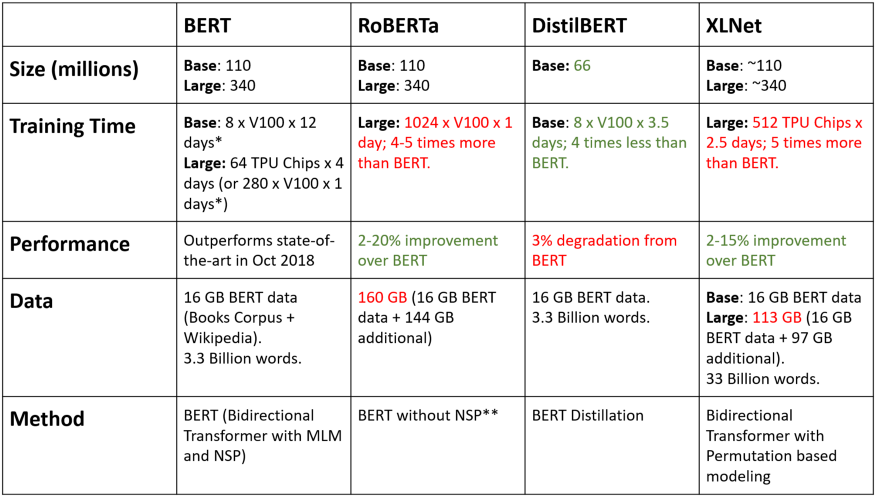

🤗Transformers brings all these models together and makes it very easy to use each with only a few lines of code. In fact they even provide us with cool tools like [pipelines](https://huggingface.co/transformers/main_classes/pipelines.html) or [live demo](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english?text=I+like+you.+I+love+you) that we can classify our text without any training or long periods of coding. But as you can geuss these simple and ready to use models have their weaknesses. For example, you can't classify the text with them with the number of labels you want because they've been pretrained on a text with specific labels. Also not all models used by them are as strong and accurate as we want them to be(for example the default model for sentiment analysis is uncased distillbert which is not the best model we can find out there). With all these in mind, we want to train 🤗Transformers models on our own data with the models that we prefer.


Thanks to this notebook on [fastai and Transformers](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta) that got me thinking of creating one for TensorFlow.

Make sure all your packages are up-to-date and then get going!

In [ ]:
!pip install --upgrade transformers
import tensorflow as tf
import tensorflow_hub as hub
import transformers
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Transformers version: ", transformers.__version__)

In [ ]:
import numpy as np
import pandas as pd

# Transformers models
# You can add to these how ever you like

from transformers import RobertaTokenizer, TFRobertaModel
from transformers import BertTokenizer, TFBertModel
from transformers import XLNetTokenizer, TFXLNetModel

from tensorflow.keras.optimizers import Adam
import os
# For text preprocessing
import string
import regex as re

#from sklearn.model_selection import StratifiedKFold

We import the data and try to clean it as much as possible, withh minimum loss of meaning. We're using a deep learning model we don't need to clean a lot of words out, because the deep learning model can find out about each word itself even it's never seen it before in its vocabulary (I've included all the explaination between the code, but make sure to ask me if anything wasn't clear to you.)

In [ ]:
test = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/test.tsv.zip', sep = '\t')
train = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/train.tsv.zip', sep = '\t')
test_ids = test.PhraseId

In [ ]:
train.head(3)

In [ ]:
# minimal cleaning because we're using a deep learning model that can
# learn from different variations and shapes of words
def clean(t, punc = True, lower = True):

    if lower is True:
        t = t.lower()
    # punctuation removal
    if punc is True:
        t = t.translate(str.maketrans('', '', string.punctuation))
        
    # removing extra space and letters
    t = re.sub("\s+", ' ', t)
    t = re.sub("\b\w\b", '', t)
    return t
# delete the unwanted columns
def delete(df_list, columns):
    for df in df_list:
        df.drop(columns = columns, inplace = True)

train['cleaned_text'] = train.Phrase.apply(lambda x: clean(x, punc = True, lower = True))
test['cleaned_text'] = test.Phrase.apply(lambda x: clean(x, punc = True, lower = True))

delete([train, test], ['Phrase', 'PhraseId', 'SentenceId'])


In [ ]:

models = {'roberta-large':(RobertaTokenizer,'roberta-large',TFRobertaModel),
          #'roberta-base':(RobertaTokenizer,'roberta-base',TFRobertaModel),
          #'bert-large':(BertTokenizer, 'bert-large-uncased', TFBertModel),
          #'bert-base':(BertTokenizer, 'bert-base-uncased', TFBertModel),
          #'xlnet':(XLNetTokenizer, 'xlnet-large-cased', TFXLNetModel)
         }

tokenizer, model_type, model_name = models['roberta-large']

Transformers models, no matter which one you choose, need a specific type of input to be able to process the data. The overall shape of the input is usually very similar, so it's not so hard to comprehend either.

In [ ]:
def make_inputs(tokenizer, model_type, serie, max_len= 70):

    tokenizer = tokenizer.from_pretrained(model_type, lowercase=True )
    tokenized_data = [tokenizer.encode_plus(text, max_length=max_len, 
                                            padding='max_length', 
                                            add_special_tokens=True,
                                            truncation = True) for text in serie]

    
    input_ids = np.array([text['input_ids'] for text in tokenized_data])
    attention_mask = np.array([text['attention_mask'] for text in tokenized_data])
    
    return input_ids, attention_mask

input_ids_train, attention_mask_train = make_inputs(tokenizer, model_type, train.cleaned_text)

Because TPU can help us alot and process the text 20 times faster I've writtern the code in a way that you can choose whether or not you want to work with TPU. On Kaggle and Colab there is a 12 hour limitation for using TPUs so you can switch between these modes by setting the value to on or off. 

In [ ]:
##### TPU or no TPU
def init_model(model_name, model_type, num_labels, Tpu = 'on', max_len = 70):
# ------------------------------------------------ with TPU --------------------------------------------------------------#
    if Tpu == 'on':
        # a few lines of code to get our tpu started and our data distributed on it
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        # print("All devices: ", tf.config.list_logical_devices('TPU'))

        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        with strategy.scope():

            model_ = model_name.from_pretrained(model_type)
            # inputs
            input_ids = tf.keras.Input(shape = (max_len, ), dtype = 'int32')
            attention_masks = tf.keras.Input(shape = (max_len,), dtype = 'int32')
            
            outputs = model_([input_ids, attention_masks])

            if 'xlnet' in model_type:
                # cls is the last token in xlnet tokenization
                outputs = outputs[0]
                cls_output = tf.squeeze(outputs[:, -1:, :], axis=1)
            else:
                cls_output = outputs[1]

            final_output = tf.keras.layers.Dense(num_labels, activation = 'softmax')(cls_output)
            model = tf.keras.Model(inputs = [input_ids, attention_masks], outputs = final_output)
            model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy',
                        metrics = ['accuracy'], )
# ------------------------------------------------ without TPU --------------------------------------------------------------#
    else:
        model_ = model_name.from_pretrained(model_type)
        # inputs
        input_ids = tf.keras.Input(shape = (max_len, ), dtype = 'int32')
        attention_masks = tf.keras.Input(shape = (max_len,), dtype = 'int32')
        
        outputs = model_([input_ids, attention_masks])

        if 'xlnet' in model_type:
            # cls is the last token in xlnet tokenization
            outputs = outputs[0]
            cls_output = tf.squeeze(outputs[:, -1:, :], axis=1)
        else:
            cls_output = outputs[1]

        
        final_output = tf.keras.layers.Dense(num_labels, activation = 'softmax')(cls_output)

        model = tf.keras.Model(inputs = [input_ids, attention_masks], outputs = final_output)

        model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
    return model
model = init_model(model_name, model_type, num_labels = 5, Tpu = 'on', max_len = 70)

In [ ]:
model.summary()

In [ ]:
train_y = tf.keras.utils.to_categorical(train.Sentiment, num_classes=5)
del train

In [ ]:
model.fit([input_ids_train, attention_mask_train], train_y,
          validation_split=0.2, epochs = 3, batch_size = 16,
          shuffle = True, verbose=2)

In [ ]:
input_ids_test, attention_mask_test = make_inputs(tokenizer, model_type, test.cleaned_text, max_len= 70)

y_pred = model.predict([input_ids_test, attention_mask_test])
pred = np.argmax(y_pred, axis = 1)
pred
sub = pd.DataFrame(np.c_[test_ids, pred], columns = ['PhraseId', 'Sentiment'])
sub.head()

In [ ]:
sub.to_csv('RoBERTa_3epochs_16bs_1e-5lr.csv', index = False)

# **Optional**

You can go on and experiment with different things as learning rate, batchsize, etc. Here as an example I wanted to find the best learning rate and I could find a great package that helped me with this task by using the fit property and fitting the model to the data after using several different lrs. The actuall phylosiphy and approach is explained in [this paper](https://arxiv.org/abs/1506.01186). Just remember to do it first hand before training so you use the best lr from the beggining.

In [ ]:
!git clone https://github.com/WittmannF/LRFinder.git
from LRFinder.keras_callback import LRFinder

In [ ]:
lr_finder = LRFinder(min_lr=1e-7, max_lr=1e-4)
model.fit([input_ids_train, attention_mask_train], train_y,
          validation_split=0.2, epochs = 1, batch_size = 16,
          shuffle = True, callbacks=[lr_finder], verbose = 2)


<h1 style="border:2px solid blue; text-align: center">Thanks for reading! Don't forget to upvote!</h1>